<a href="https://colab.research.google.com/github/YoonSungLee/AI-Innovation-Square_Vision/blob/master/Day%2015_Review%2C%20ResUnet%20tutorial/Unet_tutorial_upgrade2(assignment).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Assignment: sigmoid function to softmax function**

* mask: to categorical
* activation funtion: sigmoid -> softmax
* output shape change
* loss function: binary_crossentropy -> categorical_crossentropy
* image_show modify
* etc.

# Introduction

The U-Net model is a simple fully  convolutional neural network that is used for binary segmentation i.e foreground and background pixel-wise classification. Mainly, it consists of two parts. 

*   Contracting Path: we apply a series of conv layers and downsampling layers  (max-pooling) layers to reduce the spatial size 
*   Expanding Path: we apply a series of upsampling layers to reconstruct the spatial size of the input. 

The two parts are connected using a concatenation layers among different levels. This allows learning different features at different levels. At the end we have a simple conv 1x1 layer to reduce the number of channels to 1. 


![alt text](https://blog.playment.io/wp-content/uploads/2018/03/Screen-Shot-2018-09-05-at-3.00.03-PM.png)

# Imports

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image
import keras
from keras.models import Model
from keras.layers import Conv2D, MaxPooling2D, Input, Conv2DTranspose, Concatenate, BatchNormalization, UpSampling2D
from keras.layers import  Dropout, Activation
from keras.optimizers import Adam, SGD
from keras.layers.advanced_activations import LeakyReLU
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras import backend as K
from keras.losses import binary_crossentropy, categorical_crossentropy
from keras.utils import plot_model
import tensorflow as tf
import glob
import random
import cv2
from random import shuffle

# Dataset

We will use the The Oxford-IIIT Pet Dataset. It contains 37 classes of dogs and cats with around 200 images per each class. The dataset contains labels as bounding boxes and segmentation masks. The total number of images in the dataset is a little more than 7K. 

![alt text](http://www.robots.ox.ac.uk/~vgg/data/pets/pet_annotations.jpg)

Download the images/masks and unzip the files 

In [0]:
!wget http://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
!wget http://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz
!tar -xvzf images.tar.gz && tar -xvzf annotations.tar.gz
!rm  images/*.mat

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
annotations/trimaps/pomeranian_180.png
annotations/trimaps/._pomeranian_181.png
annotations/trimaps/pomeranian_181.png
annotations/trimaps/._pomeranian_182.png
annotations/trimaps/pomeranian_182.png
annotations/trimaps/._pomeranian_183.png
annotations/trimaps/pomeranian_183.png
annotations/trimaps/._pomeranian_184.png
annotations/trimaps/pomeranian_184.png
annotations/trimaps/._pomeranian_185.png
annotations/trimaps/pomeranian_185.png
annotations/trimaps/._pomeranian_186.png
annotations/trimaps/pomeranian_186.png
annotations/trimaps/._pomeranian_187.png
annotations/trimaps/pomeranian_187.png
annotations/trimaps/._pomeranian_188.png
annotations/trimaps/pomeranian_188.png
annotations/trimaps/._pomeranian_189.png
annotations/trimaps/pomeranian_189.png
annotations/trimaps/._pomeranian_19.png
annotations/trimaps/pomeranian_19.png
annotations/trimaps/._pomeranian_190.png
annotations/trimaps/pomeranian_190.png
annotations/trimaps/._pomeranian_191.png
annota

Note that we have two foulders. The first one is `images` which contains the raw images and annotation which contains the masks as a `binary` foulder image.

# Generators

In [0]:
def image_generator(files, batch_size = 32, sz = (256, 256)):
  
  while True: 
    
    #extract a random batch
    batch = np.random.choice(files, size = batch_size)
    
    #variables for collecting batches of inputs and outputs
    batch_x = [] # inputs : image
    batch_y = [] # outputs : mask
    
    
    for f in batch:

        #get the masks. Note that masks are png files
        mask_object = Image.open(f'annotations/trimaps/{f[:-4]}.png')
        mask_object = np.array(mask_object.resize(sz))


        #preprocess the mask 
        mask_object[mask_object >= 2] = 0 # background
        mask_object[mask_object != 0 ] = 1 # object
        mask_background = 1 - mask_object

        mask_object = np.expand_dims(mask_object, 2)
        mask_background = np.expand_dims(mask_background, 2)

        mask = np.concatenate((mask_object, mask_background), axis=2)

        batch_y.append(mask)

        #preprocess the raw images 
        raw = Image.open(f'images/{f}')
        raw = raw.resize(sz)
        raw = np.array(raw)

        #check the number of channels because some of the images are RGBA or GRAY
        if len(raw.shape) == 2: # if the image is GRAY scale
          raw = np.stack((raw,)*3, axis=-1) # 1 channel GRAY image change to 3 channels GRAY image

        else:
          raw = raw[:,:,0:3]

        batch_x.append(raw) # raw.shape = (256, 256, 3)

    #preprocess a batch of images and masks 
    batch_x = np.array(batch_x)/255. # batch_x.shape = (N, 256, 256, 3)
    batch_y = np.array(batch_y)
    # batch_y = np.expand_dims(batch_y,3)

    yield (batch_x, batch_y)
    

### Python의 yield 키워드 알아보기
* https://tech.ssut.me/what-does-the-yield-keyword-do-in-python/

In [0]:
batch_size = 32

all_files = os.listdir('images')
shuffle(all_files)

split = int(0.95 * len(all_files))

#split into training and testing
train_files = all_files[0:split]
test_files  = all_files[split:]

train_generator = image_generator(train_files, batch_size = batch_size)
test_generator  = image_generator(test_files, batch_size = batch_size)

In [0]:
x, y= next(train_generator)

ValueError: ignored

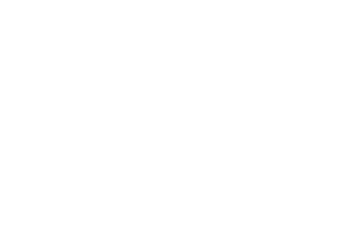

In [0]:
plt.axis('off')
img = x[0]
msk = y[0].squeeze()
msk = np.stack((msk,)*3, axis=-1)

plt.imshow( np.concatenate([img, msk, img*msk], axis = 1))

# IoU metric

The intersection over union (IoU) metric is a simple metric used to evaluate the performance of a segmentation algorithm. Given two masks $x_{true}, x_{pred}$ we evaluate 

$$IoU = \frac{y_{true} \cap y_{pred}}{y_{true} \cup y_{pred}}$$

In [0]:
def mean_iou(y_true, y_pred):
    yt0 = y_true[:,:,:,0]
    yp0 = K.cast(y_pred[:,:,:,0] > 0.5, 'float32')
    inter = tf.count_nonzero(tf.logical_and(tf.equal(yt0, 1), tf.equal(yp0, 1)))
    union = tf.count_nonzero(tf.add(yt0, yp0))
    iou = tf.where(tf.equal(union, 0), 1., tf.cast(inter/union, 'float32'))
    return iou

# bce_dice_loss

In [0]:
def dice_coef(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)


def dice_loss(y_true, y_pred):
    smooth = 1.
    y_pred = K.cast(y_pred[:,:,:,0] > 0.5, 'float32')
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = y_true_f * y_pred_f
    score = (2. * K.sum(intersection) + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return 1. - score

# loss function definition
def bce_dice_loss(y_true, y_pred):
    return categorical_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)

<img src="https://i.imgur.com/g8AehnR.png" width="100%">

<img src="https://i.imgur.com/tuCJnpi.png" width="100%">

<img src="https://i.imgur.com/6aUob5F.png" width="100%">

<img src="https://i.imgur.com/09DU1iQ.png" width="100%">

# Model

In [0]:
def unet(sz = (256, 256, 3)):
  x = Input(sz)
  inputs = x
  
  #Contracting layers
  nKernels = 16
  layers = [] # for skip connection

  # level_1 (256, 256, 16)
  # level + layer
  layer11 = Conv2D(nKernels, 3, activation='relu', padding='same', kernel_initializer='he_normal', use_bias=False) (x)
  layer11 = BatchNormalization()(layer11)
  layer12 = Conv2D(nKernels*2, 3, activation='relu', padding='same', kernel_initializer='he_normal', use_bias=False) (layer11)
  layer12 = BatchNormalization()(layer12)
  layers.append(layer12) # for skip connection
  layer13 = MaxPooling2D() (layer12)
  
  # level_2 (128, 128, 32)
  layer21 = Conv2D(nKernels*2, 3, activation='relu', padding='same', kernel_initializer='he_normal', use_bias=False) (layer13)
  layer21 = BatchNormalization()(layer21)
  layer22 = Conv2D(nKernels*4, 3, activation='relu', padding='same', kernel_initializer='he_normal', use_bias=False) (layer21)
  layer22 = BatchNormalization()(layer22)
  layers.append(layer22) # for skip connection
  layer23 = MaxPooling2D() (layer22)

  # level_3 (64, 64, 64)
  layer31 = Conv2D(nKernels*4, 3, activation='relu', padding='same', kernel_initializer='he_normal', use_bias=False) (layer23)
  layer31 = BatchNormalization()(layer31)
  layer32 = Conv2D(nKernels*8, 3, activation='relu', padding='same', kernel_initializer='he_normal', use_bias=False) (layer31)
  layer32 = BatchNormalization()(layer32)
  layers.append(layer32) # for skip connection
  layer33 = MaxPooling2D() (layer32)

  # level_4 (32, 32, 128)
  layer41 = Conv2D(nKernels*8, 3, activation='relu', padding='same', kernel_initializer='he_normal', use_bias=False) (layer33)
  layer41 = BatchNormalization()(layer41)
  layer42 = Conv2D(nKernels*16, 3, activation='relu', padding='same', kernel_initializer='he_normal', use_bias=False) (layer41)
  layer42 = BatchNormalization()(layer42)
  layers.append(layer42) # for skip connection
  layer43 = MaxPooling2D() (layer42)

  # level_5 (16, 16, 256)
  layer51 = Conv2D(nKernels*16, 3, activation='relu', padding='same', kernel_initializer='he_normal', use_bias=False) (layer43)
  layer51 = BatchNormalization()(layer51)
  layer52 = Conv2D(nKernels*32, 3, activation='relu', padding='same', kernel_initializer='he_normal', use_bias=False) (layer51)
  layer52 = BatchNormalization()(layer52)
  layers.append(layer52) # for skip connection
  layer53 = MaxPooling2D() (layer52)

  # level_6 (8, 8, 512)
  layer61 = Conv2D(nKernels*32, 3, activation='relu', padding='same', kernel_initializer='he_normal', use_bias=False) (layer53)
  layer61 = BatchNormalization()(layer61)
  layer62 = Conv2D(nKernels*64, 3, activation='relu', padding='same', kernel_initializer='he_normal', use_bias=False) (layer61)
  layer62 = BatchNormalization()(layer62)
  layers.append(layer62) # for skip connection
  layer63 = MaxPooling2D() (layer62)
  
  # BottleNeck (4, 4, 1024)
  bottleneck11 = Conv2D(nKernels*64, 3, activation='relu', padding='same', kernel_initializer='he_normal', use_bias=False) (layer63)
  bottleneck11 = BatchNormalization()(bottleneck11)
  bottleneck12 = Conv2D(nKernels*64, 3, activation='relu', padding='same', kernel_initializer='he_normal', use_bias=False) (bottleneck11)
  bottleneck12 = BatchNormalization()(bottleneck12)
  bottleneck13 = Conv2DTranspose(nKernels*32, 2, strides=(2, 2), padding='same') (bottleneck12)
  # (8, 8, 512)
  level = len(layers) - 1 # 6-1
  layer71 = Concatenate(axis=3)([bottleneck13, layers[level]]) # (B, H, W, C) == axis(0,1,2,3)
  
  # level 7 = level 6
  layer72 = Conv2D(nKernels*32, 3, activation='relu', padding='same', kernel_initializer='he_normal', use_bias=False) (layer71)
  layer72 = BatchNormalization()(layer72)
  layer73 = Conv2D(nKernels*32, 3, activation='relu', padding='same', kernel_initializer='he_normal', use_bias=False) (layer72)
  layer73 = BatchNormalization()(layer73)
  layer74 = Conv2DTranspose(nKernels*16, 2, strides=(2, 2), padding='same') (layer73)
  level = len(layers) - 2 # 6-2
  layer81 = Concatenate(axis=3)([layer74, layers[level]])
  
  # level 8 = level 5
  layer82 = Conv2D(nKernels*16, 3, activation='relu', padding='same', kernel_initializer='he_normal', use_bias=False) (layer81)
  layer82 = BatchNormalization()(layer82)
  layer83 = Conv2D(nKernels*16, 3, activation='relu', padding='same', kernel_initializer='he_normal', use_bias=False) (layer82)
  layer83 = BatchNormalization()(layer83)
  layer84 = Conv2DTranspose(nKernels*8, 2, strides=(2, 2), padding='same') (layer83)
  level = len(layers) - 3 # 6-3
  layer91 = Concatenate(axis=3)([layer84, layers[level]])

  # level 9 = level 4
  layer92 = Conv2D(nKernels*8, 3, activation='relu', padding='same', kernel_initializer='he_normal', use_bias=False) (layer91)
  layer92 = BatchNormalization()(layer92)
  layer93 = Conv2D(nKernels*8, 3, activation='relu', padding='same', kernel_initializer='he_normal', use_bias=False) (layer92)
  layer93 = BatchNormalization()(layer93)
  layer94 = Conv2DTranspose(nKernels*4, 2, strides=(2, 2), padding='same') (layer93)
  level = len(layers) - 4 # 6-4
  layer101 = Concatenate(axis=3)([layer94, layers[level]])

  # level 10 = level 3
  layer102 = Conv2D(nKernels*4, 3, activation='relu', padding='same', kernel_initializer='he_normal', use_bias=False) (layer101)
  layer102 = BatchNormalization()(layer102)
  layer103 = Conv2D(nKernels*4, 3, activation='relu', padding='same', kernel_initializer='he_normal', use_bias=False) (layer102)
  layer103 = BatchNormalization()(layer103)
  layer104 = Conv2DTranspose(nKernels*2, 2, strides=(2, 2), padding='same') (layer103)
  level = len(layers) - 5 # 6-5
  layer111 = Concatenate(axis=3)([layer104, layers[level]])
  
  # level 11 = level 2
  layer112 = Conv2D(nKernels*2, 3, activation='relu', padding='same', kernel_initializer='he_normal', use_bias=False) (layer111)
  layer112 = BatchNormalization()(layer112)
  layer113 = Conv2D(nKernels*2, 3, activation='relu', padding='same', kernel_initializer='he_normal', use_bias=False) (layer112)
  layer113 = BatchNormalization()(layer113)
  layer114 = Conv2DTranspose(nKernels, 2, strides=(2, 2), padding='same') (layer113)
  level = len(layers) - 6 # 6-6
  layer121 = Concatenate(axis=3)([layer114, layers[level]])
      
  #level 1 = classification 
  classification1 = Conv2D(nKernels, 3, activation='relu', padding='same', kernel_initializer='he_normal', use_bias=False) (layer121)
  classification1 = BatchNormalization()(classification1)
  classification2 = Conv2D(nKernels, 3, activation='relu', padding='same', kernel_initializer='he_normal', use_bias=False) (classification1)
  classification2 = BatchNormalization()(classification2)
  outputs = Conv2D(2, 1, activation='softmax') (classification2)
  
  #model creation 
  model = Model(inputs=[inputs], outputs=[outputs])
  model.compile(optimizer = 'rmsprop', loss = bce_dice_loss, metrics = [mean_iou])
  
  return model

In [0]:
model = unet()

In [0]:
model.summary()

# Callbacks

Simple functions to save the model at each epoch and show some predictions 

In [0]:
def build_callbacks():
        checkpointer = ModelCheckpoint(filepath='unet.h5', verbose=0, save_best_only=True, save_weights_only=True)
        callbacks = [checkpointer, PlotLearning()]
        return callbacks

# inheritance for training process plot 
class PlotLearning(keras.callbacks.Callback):

    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        self.acc = []
        self.val_acc = []
        #self.fig = plt.figure()
        self.logs = []
    def on_epoch_end(self, epoch, logs={}):
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.acc.append(logs.get('mean_iou'))
        self.val_acc.append(logs.get('val_mean_iou'))
        self.i += 1
        print('i=',self.i,'loss=',logs.get('loss'),'val_loss=',logs.get('val_loss'),'mean_iou=',logs.get('mean_iou'),'val_mean_iou=',logs.get('val_mean_iou'))
        
        #choose a random test image and preprocess
        path = np.random.choice(test_files)
        raw = Image.open(f'images/{path}')
        raw = np.array(raw.resize((256, 256)))/255.
        raw = raw[:,:,0:3]
        
        #predict the mask 
        pred = model.predict(np.expand_dims(raw, 0))
        pred = pred[0]
        

        #mask post-processing 
        msk  = pred.squeeze()
        msk = np.stack((msk,)*3, axis=-1)
        msk[msk >= 0.5] = 1 
        msk[msk < 0.5] = 0 
        
        #show the mask and the segmented image 
        combined = np.concatenate([raw, msk, raw* msk], axis = 1)
        plt.axis('off')
        plt.imshow(combined)
        plt.show()

# Training



i= 1 loss= 0.7614951135088864 val_loss= 1.0908284295688977 mean_iou= 0.5221508588284662 val_mean_iou= 0.6041608127680692


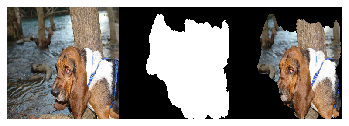

i= 2 loss= 0.4720482076411922 val_loss= 0.5490805262869055 mean_iou= 0.6729284416050672 val_mean_iou= 0.6589828025210988


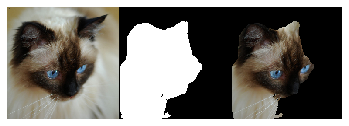

i= 3 loss= 0.38410397207355934 val_loss= 0.561878274787556 mean_iou= 0.7277642572851486 val_mean_iou= 0.6714885885065253


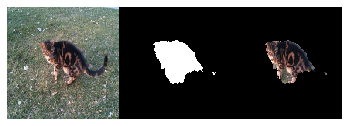

i= 4 loss= 0.3378500960188914 val_loss= 0.37595602057196875 mean_iou= 0.7563191597864508 val_mean_iou= 0.7485383586450056


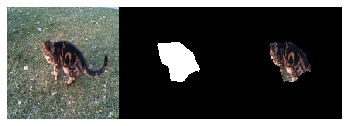

i= 5 loss= 0.3000598290603455 val_loss= 0.3484498181126334 mean_iou= 0.782302246518331 val_mean_iou= 0.7644396424293518


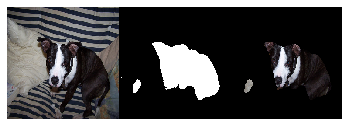

i= 6 loss= 0.2794465783252019 val_loss= 0.298764941367236 mean_iou= 0.7970112262795505 val_mean_iou= 0.7896086790344932


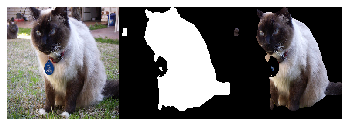

i= 7 loss= 0.2565664221026582 val_loss= 0.4356648623943329 mean_iou= 0.8126639329135146 val_mean_iou= 0.7287938703190197


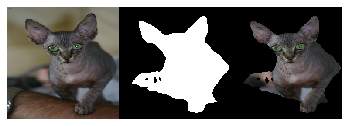

i= 8 loss= 0.24335629394337466 val_loss= 0.30774483626539056 mean_iou= 0.8217824403553793 val_mean_iou= 0.7718062725934115


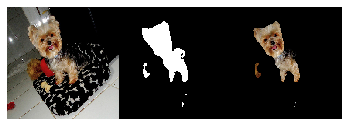

i= 9 loss= 0.22587280587790765 val_loss= 0.31786429611119354 mean_iou= 0.833626712566097 val_mean_iou= 0.7740780765360052


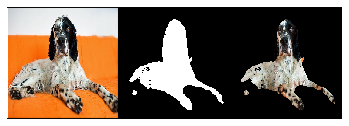

i= 10 loss= 0.2122368187937018 val_loss= 0.30182640931823035 mean_iou= 0.8422065105068085 val_mean_iou= 0.7953896414149891


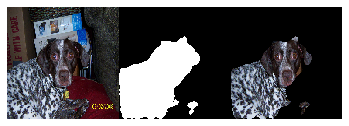

i= 11 loss= 0.20718440556362883 val_loss= 0.2826356156305833 mean_iou= 0.847085082367675 val_mean_iou= 0.8121090585535223


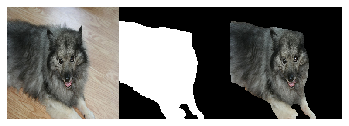

i= 12 loss= 0.19075459942697934 val_loss= 0.2715407637032596 mean_iou= 0.8571318657430884 val_mean_iou= 0.8194609772075306


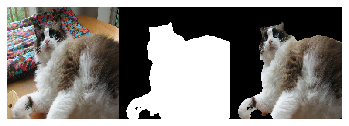

i= 13 loss= 0.18566660161159898 val_loss= 0.3043674989180131 mean_iou= 0.8612705967197679 val_mean_iou= 0.7964177619327198


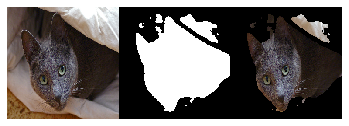

i= 14 loss= 0.17753319551139118 val_loss= 0.25326628712090576 mean_iou= 0.8656225795070874 val_mean_iou= 0.8233055147257718


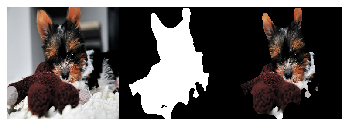

i= 15 loss= 0.17065732517879303 val_loss= 0.2740463343533603 mean_iou= 0.8707217146816864 val_mean_iou= 0.7974374240094965


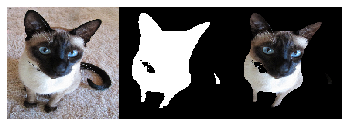

i= 16 loss= 0.164651351330215 val_loss= 0.26031949438832025 mean_iou= 0.8757610470736952 val_mean_iou= 0.8190059011632745


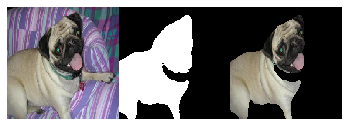

i= 17 loss= 0.15448371334571273 val_loss= 0.2507570128549229 mean_iou= 0.8830522244379401 val_mean_iou= 0.8208724531260404


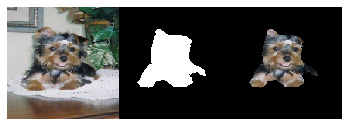

i= 18 loss= 0.152478925067268 val_loss= 0.27538591758771375 mean_iou= 0.8837001095079395 val_mean_iou= 0.8168089281428944


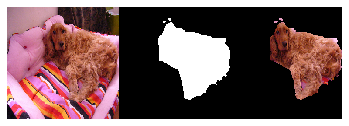

i= 19 loss= 0.14432043629830285 val_loss= 0.2521527964960445 mean_iou= 0.8898310762017829 val_mean_iou= 0.8341460173780267


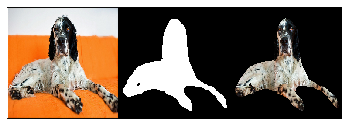

i= 20 loss= 0.14301080389382087 val_loss= 0.27796207639304077 mean_iou= 0.8908408433879347 val_mean_iou= 0.8192541707645763


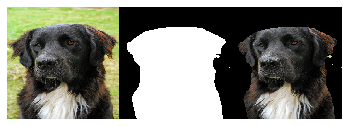

i= 21 loss= 0.13759138009863903 val_loss= 0.23931030387228186 mean_iou= 0.8946537062457708 val_mean_iou= 0.8308516253124584


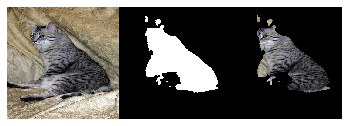

i= 22 loss= 0.13411786975381582 val_loss= 0.23536386273124002 mean_iou= 0.8962052165101108 val_mean_iou= 0.8392958586866205


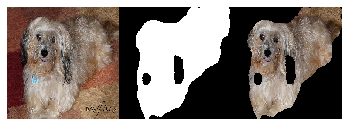

i= 23 loss= 0.12893740860022365 val_loss= 0.2091371552510695 mean_iou= 0.8999534279244131 val_mean_iou= 0.8563465421850031


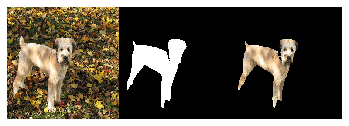

i= 24 loss= 0.12415896696314964 val_loss= 0.2671337263150649 mean_iou= 0.903917020042193 val_mean_iou= 0.8243096145716581


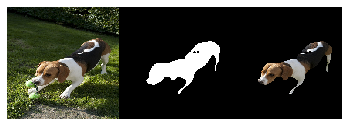

i= 25 loss= 0.121717275549832 val_loss= 0.23089096491987054 mean_iou= 0.9045367093935405 val_mean_iou= 0.8369540788910605


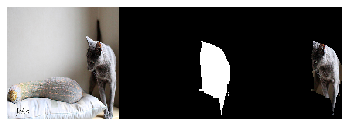

i= 26 loss= 0.11758393858937913 val_loss= 0.24057864059101453 mean_iou= 0.9081612675701647 val_mean_iou= 0.8329039324413646


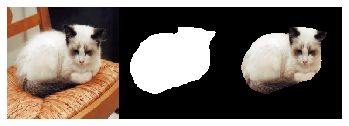

i= 27 loss= 0.11392517643023843 val_loss= 0.2139019708741795 mean_iou= 0.9105329644190122 val_mean_iou= 0.8546818982471119


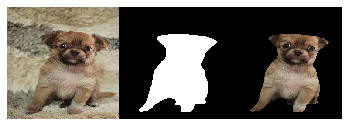

i= 28 loss= 0.11051288992166519 val_loss= 0.2873101139610464 mean_iou= 0.9132868176725901 val_mean_iou= 0.8214659257368608


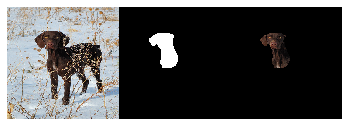

i= 29 loss= 0.10707046248052762 val_loss= 0.2550310506062074 mean_iou= 0.9158723754425572 val_mean_iou= 0.84460003267635


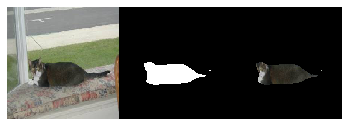

i= 30 loss= 0.10488217085872066 val_loss= 0.24665417318994348 mean_iou= 0.9180369151237349 val_mean_iou= 0.8424315452575684


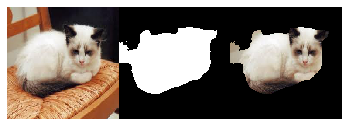

In [0]:
train_steps = len(train_files) //batch_size
test_steps = len(test_files) //batch_size
model.fit_generator(train_generator, 
                    epochs = 30, steps_per_epoch = train_steps,validation_data = test_generator, validation_steps = test_steps,
                    callbacks = build_callbacks(), verbose = 0) # verbose : 0=학습로고표시안함, 1=표시함

# Testing

In [0]:
!wget http://r.ddmcdn.com/s_f/o_1/cx_462/cy_245/cw_1349/ch_1349/w_720/APL/uploads/2015/06/caturday-shutterstock_149320799.jpg -O test.jpg

--2020-03-05 11:25:09--  http://r.ddmcdn.com/s_f/o_1/cx_462/cy_245/cw_1349/ch_1349/w_720/APL/uploads/2015/06/caturday-shutterstock_149320799.jpg
Resolving r.ddmcdn.com (r.ddmcdn.com)... 99.84.168.121, 99.84.168.79, 99.84.168.109, ...
Connecting to r.ddmcdn.com (r.ddmcdn.com)|99.84.168.121|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 63219 (62K) [image/jpeg]
Saving to: ‘test.jpg’

test.jpg            100%[===================>]  61.74K  --.-KB/s    in 0.02s   

2020-03-05 11:25:09 (3.78 MB/s) - ‘test.jpg’ saved [63219/63219]



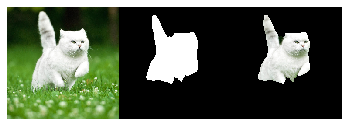

In [0]:
raw = Image.open('test.jpg')
raw = np.array(raw.resize((256, 256)))/255.
raw = raw[:,:,0:3]

#predict the mask 
pred = model.predict(np.expand_dims(raw, 0))

#mask post-processing 
msk  = pred.squeeze()
msk = np.stack((msk,)*3, axis=-1)
msk[msk >= 0.5] = 1 
msk[msk < 0.5] = 0 

#show the mask and the segmented image 
combined = np.concatenate([raw, msk, raw* msk], axis = 1)
plt.axis('off')
plt.imshow(combined)
plt.show()

# ResUnet

In [0]:
def conv_block(x, filters, kernel_size=3, padding='same', strides=1):
    'convolutional layer which always uses the batch normalization layer'
    conv = Conv2D(filters, kernel_size, kernel_initializer='he_normal', padding=padding, strides=strides)(x)
    conv = BatchNormalization()(conv)
    conv = Activation('relu')(conv)
    return conv


def residual_block(x, filters, kernel_size=3, padding='same', strides=1):
    res = conv_block(x, filters, kernel_size, padding, strides)
    res = conv_block(res, filters, kernel_size, padding, strides)
    output = Add()([x, res])
    return output

<img src="https://i.imgur.com/WpmvkGg.png" width="100%">

<img src="https://i.imgur.com/QMvJyyk.png" width="100%">

# References


1.   http://deeplearning.net/tutorial/unet.html
2.   https://github.com/ldenoue/keras-unet



# 성능을 더 높이는 방법

* BottleNeck 제거
* BatchNormalization Layer 적용
* kernel_initializer = 'he_normal'
* FeatureMap의 개수(nKernels) 증가
* top layer부분에 Dropout 적용
* 마지막 layer의 activation function을 'sigmoid'에서 'softmax'로 변경
 * outputs = Conv2D(2, 1, activation='softmax') (classification2)
* loss function을 bce_dice_loss로 변경
* encoding과 decoding의 level을 증가시키는 방법은 overfitting이 발생할 수 있기 때문에 효과적인 방법은 아님